In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import rasterio
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report
)
from shapely.geometry import Point
from affine import Affine
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load CSV Data
csv_file_path = r'E:\Hackathon\Model\REE\mineral_prospectivity_REE.csv'             # User input
try:
    df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded data from: {csv_file_path}")
    print(f"\nData shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_file_path}'. Please check the path.")
    exit()

# Display the first few rows
print("\nFirst 5 rows of your data:")
print(df.head())

Successfully loaded data from: E:\Hackathon\Model\REE\mineral_prospectivity_REE.csv

Data shape: (3857456, 28)

First 5 rows of your data:
    X_Coordinate  Y_Coordinate  norm_Lith_REE  norm_gr_ree  norm_Line_density  \
0  785400.214219  1.743053e+06       0.444444          1.0           0.000004   
1  785500.226538  1.743053e+06       0.444444          1.0           0.000015   
2  785600.238857  1.743053e+06       0.444444          1.0           0.000031   
3  785700.251176  1.743053e+06       0.444444          1.0           0.000056   
4  785800.263495  1.743053e+06       0.444444          1.0           0.000084   

   norm_Line_ring  norm_intersect  norm_gr_sch  norm_vein  norm_dyke  ...  \
0        0.804111             0.0          0.0        0.0        0.0  ...   
1        0.833333             0.0          0.0        0.0        0.0  ...   
2        0.833333             0.0          0.0        0.0        0.0  ...   
3        0.833333             0.0          0.0        0.0        0

In [4]:
# Basic Data Inspection and Define Features and Target
print("\nDataFrame Info:")
df.info()

latitude_column = 'Y_Coordinate'                              # User input
longitude_column = 'X_Coordinate'                             # User input

if latitude_column in df.columns and longitude_column in df.columns:
    latitudes = df[latitude_column]
    longitudes = df[longitude_column]
    print(f"\nLatitude column '{latitude_column}' and Longitude column '{longitude_column}' defined and stored.")
else:
    print(f"\nError: Latitude column '{latitude_column}' or Longitude column '{longitude_column}' not found.")
    print("Please check your CSV header and ensure these columns exist.")
    exit()

all_columns = df.columns.tolist()
feature_columns = all_columns[2:-1]
target_column = all_columns[-1]

# Verify that specified feature columns exist in the DataFrame
if not all(col in df.columns for col in feature_columns):
    missing_features = [col for col in feature_columns if col not in df.columns]
    print(f"\nError: The following feature columns are missing from your CSV: {missing_features}")
    print("Please check your 'feature_columns' list and CSV header.")
    exit()

if target_column not in df.columns:
    print(f"\nError: The target column '{target_column}' is missing from your CSV.")
    print("Please check your 'target_column' variable and CSV header.")
    exit()

# Assign features (X) and target (y)
X = df[feature_columns]
y = df[target_column]

print(f"\nFeatures (X) shape: {X.shape}")
print(feature_columns)
print(f"\nOriginal Target (y) shape: {y.shape}")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857456 entries, 0 to 3857455
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   X_Coordinate           float64
 1   Y_Coordinate           float64
 2   norm_Lith_REE          float64
 3   norm_gr_ree            float64
 4   norm_Line_density      float64
 5   norm_Line_ring         float64
 6   norm_intersect         float64
 7   norm_gr_sch            float64
 8   norm_vein              float64
 9   norm_dyke              float64
 10  norm_Th                float64
 11  norm_U                 float64
 12  norm_pca3              float64
 13  normalized_BA          float64
 14  normalized_BA_res      float64
 15  normalized_BA_res_vdr  float64
 16  normalized_BA_tdr      float64
 17  normalized_BA_up5      float64
 18  normalized_MA          float64
 19  norm_MA_rtp            float64
 20  norm_MA_rtpres         float64
 21  normalized_MA_ana      float64
 22  n

In [5]:
# Modify the target column to keep only 0 and 1, setting others to NaN
print("Modifying target column to keep only 0 and 1, setting others to NaN...")
valid_target_values = [0, 1]
y[~y.isin(valid_target_values)] = pd.NA

print("\nModified Target Variable ('y') Distribution:")
print(y.value_counts(dropna=False))
print(y.value_counts(dropna=False, normalize=True))

print(f"\nModified Target (y) shape: {y.shape}")

Modifying target column to keep only 0 and 1, setting others to NaN...

Modified Target Variable ('y') Distribution:
REE_target
NaN    3770964
0.0      68448
1.0      18044
Name: count, dtype: int64
REE_target
NaN    0.977578
0.0    0.017744
1.0    0.004678
Name: proportion, dtype: float64

Modified Target (y) shape: (3857456,)


In [6]:
# Handle Missing Values
print("Checking for missing values...")
print(X.isnull().sum())

# Simple mean imputation for numerical features
for col in X.columns:
    if X[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X[col]):
            mean_val = X[col].mean()
            X[col].fillna(mean_val, inplace=True)
            print(f"Filled missing values in '{col}' with mean: {mean_val:.2f}")
        else:
            # For non-numeric (e.g., categorical) features, fill with mode or a specific string
            mode_val = X[col].mode()[0]
            X[col].fillna(mode_val, inplace=True)
            print(f"Filled missing values in '{col}' with mode: {mode_val}")

print("\nMissing values after imputation:")
print(X.isnull().sum())
print("\nMissing values handled.")

Checking for missing values...
norm_Lith_REE            0
norm_gr_ree              0
norm_Line_density        0
norm_Line_ring           0
norm_intersect           0
norm_gr_sch              0
norm_vein                0
norm_dyke                0
norm_Th                  0
norm_U                   0
norm_pca3                0
normalized_BA            0
normalized_BA_res        0
normalized_BA_res_vdr    0
normalized_BA_tdr        0
normalized_BA_up5        0
normalized_MA            0
norm_MA_rtp              0
norm_MA_rtpres           0
normalized_MA_ana        0
normalized_MA_res        0
normalized_MA_up5        0
norm_Dose_TC             0
norm_K                   0
norm_Silica              0
dtype: int64

Missing values after imputation:
norm_Lith_REE            0
norm_gr_ree              0
norm_Line_density        0
norm_Line_ring           0
norm_intersect           0
norm_gr_sch              0
norm_vein                0
norm_dyke                0
norm_Th                  0
norm

In [7]:
print("Creating subset for training and testing with target values 0 or 1...")

# Filter rows where the target column is either 0 or 1
df_filtered = df[df[target_column].isin([0, 1])]

# Define X_subset and y_subset from the filtered DataFrame
X_subset = df_filtered[feature_columns]
y_subset = df_filtered[target_column]

print(f"\nSubset created. Features (X_subset) shape: {X_subset.shape}")
print(f"Target (y_subset) shape: {y_subset.shape}")

print("\nDistribution of Gold_target in the subset:")
print(y_subset.value_counts())
print(y_subset.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nThis subset (X_subset, y_subset) with target values 0 or 1 will now be used for splitting, testing, and training.")

Creating subset for training and testing with target values 0 or 1...

Subset created. Features (X_subset) shape: (86492, 25)
Target (y_subset) shape: (86492,)

Distribution of Gold_target in the subset:
REE_target
0.0    68448
1.0    18044
Name: count, dtype: int64
REE_target
0.0    79.14%
1.0    20.86%
Name: proportion, dtype: object

This subset (X_subset, y_subset) with target values 0 or 1 will now be used for splitting, testing, and training.


In [8]:
# Data Splitting and Feature Scaling
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.30, random_state=42, stratify=y_subset)

print(f"Training set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Testing set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")
print(f"\nTraining set 'target_deposit' distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing set 'target_deposit' distribution:\n{y_test.value_counts(normalize=True)}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeatures scaled using StandardScaler.")
print("\nFirst 5 rows of scaled training features:")
print(X_train_scaled.head())

Training set shape (X_train, y_train): (60544, 25), (60544,)
Testing set shape (X_test, y_test): (25948, 25), (25948,)

Training set 'target_deposit' distribution:
REE_target
0.0    0.791375
1.0    0.208625
Name: proportion, dtype: float64
Testing set 'target_deposit' distribution:
REE_target
0.0    0.79139
1.0    0.20861
Name: proportion, dtype: float64

Features scaled using StandardScaler.

First 5 rows of scaled training features:
         norm_Lith_REE  norm_gr_ree  norm_Line_density  norm_Line_ring  \
325163        1.114073     2.086248          -0.385183        0.422617   
2874760       1.114073     2.086248           0.448250        0.422617   
2870222      -0.657278    -0.091561          -0.582686        0.407095   
3491804       0.016498    -0.312731          -1.302445       -2.077113   
2434480       0.016498    -0.312731          -1.278529       -0.688374   

         norm_intersect  norm_gr_sch  norm_vein  norm_dyke   norm_Th  \
325163        -0.607501    -0.481396  -0.387

In [9]:
# Model Selection and Training

# Initialize a dictionary to store models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True, random_state=42, class_weight='balanced'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42, use_label_encoder=False, scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])),
    'SVC': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', metric='minkowski', p=2),
    'ANN (MLP)': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42, alpha=0.0001, learning_rate='adaptive', early_stopping=True, n_iter_no_change=10),
}

# Dictionary to store performance metrics for each model
model_performance = {}

# Dictionary to store predictions and probabilities for plotting
model_predictions = {}

print("Starting model training for multiple algorithms...")

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    try:
        if name == 'K-Nearest Neighbors':
            model.fit(X_train_scaled, y_train)
        elif name == 'ANN (MLP)':
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)

        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            print(f"  Warning: {name} does not have predict_proba. ROC AUC will not be calculated.")
            y_pred_proba = np.zeros_like(y_pred, dtype=float) # Dummy values


        # Store predictions
        model_predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if hasattr(model, 'predict_proba') else np.nan

        model_performance[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': roc_auc
        }

        print(f"  {name} - Training Complete.")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  AUC-ROC: {roc_auc:.4f}")
        print("\n  Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

    except Exception as e:
        print(f"  Error training {name}: {e}")

print("\nAll models trained and evaluated on test set.")

# Convert performance dict to DataFrame for easy viewing
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
print("\nModel Performance Summary:")
print(performance_df.sort_values(by='AUC-ROC', ascending=False))

# Save the performance summary table to a CSV file
output_file = r'E:\Hackathon\Model\REE\model_performance_summary.csv'                     # User input
performance_df.sort_values(by='AUC-ROC', ascending=False).to_csv(output_file)
print(f"\nModel performance summary saved to '{output_file}'")

Starting model training for multiple algorithms...

--- Training Logistic Regression ---
  Logistic Regression - Training Complete.
  Accuracy: 0.9071
  Precision: 0.7236
  Recall: 0.8973
  F1-Score: 0.8012
  AUC-ROC: 0.9667

  Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     20535
         1.0       0.72      0.90      0.80      5413

    accuracy                           0.91     25948
   macro avg       0.85      0.90      0.87     25948
weighted avg       0.92      0.91      0.91     25948


--- Training Decision Tree ---
  Decision Tree - Training Complete.
  Accuracy: 0.9990
  Precision: 0.9978
  Recall: 0.9974
  F1-Score: 0.9976
  AUC-ROC: 0.9984

  Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20535
         1.0       1.00      1.00      1.00      5413

    accuracy                           1.00     25948
   macro avg    

C:\ProgramData\anaconda3\envs\hack_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGBoost - Training Complete.
  Accuracy: 0.9997
  Precision: 0.9993
  Recall: 0.9993
  F1-Score: 0.9993
  AUC-ROC: 1.0000

  Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20535
         1.0       1.00      1.00      1.00      5413

    accuracy                           1.00     25948
   macro avg       1.00      1.00      1.00     25948
weighted avg       1.00      1.00      1.00     25948


--- Training SVC ---
  SVC - Training Complete.
  Accuracy: 0.9975
  Precision: 0.9894
  Recall: 0.9987
  F1-Score: 0.9940
  AUC-ROC: 0.9999

  Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20535
         1.0       0.99      1.00      0.99      5413

    accuracy                           1.00     25948
   macro avg       0.99      1.00      1.00     25948
weighted avg       1.00      1.00      1.00     25948


--- Training K-Nearest Neig

Generating comparative plots...


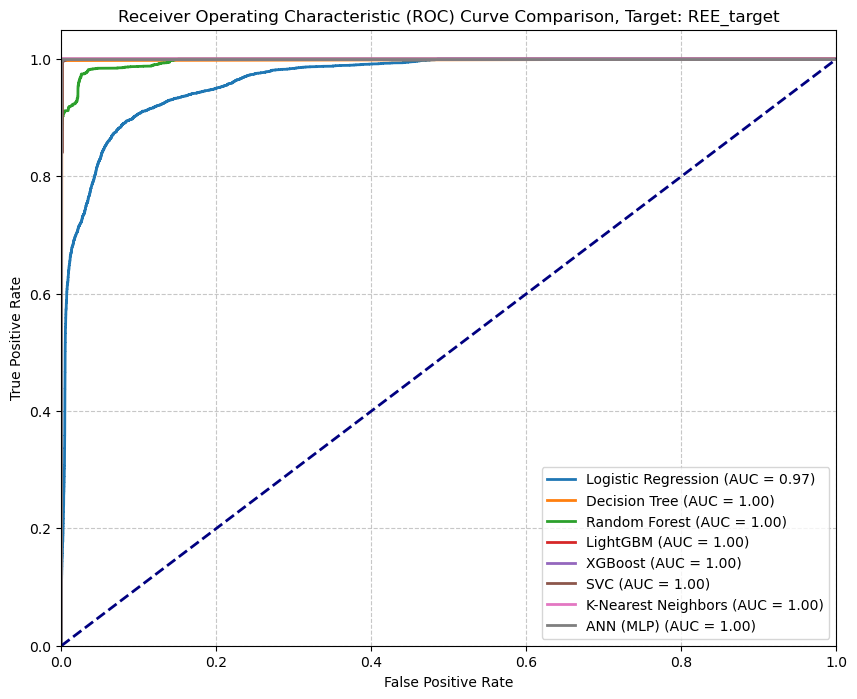

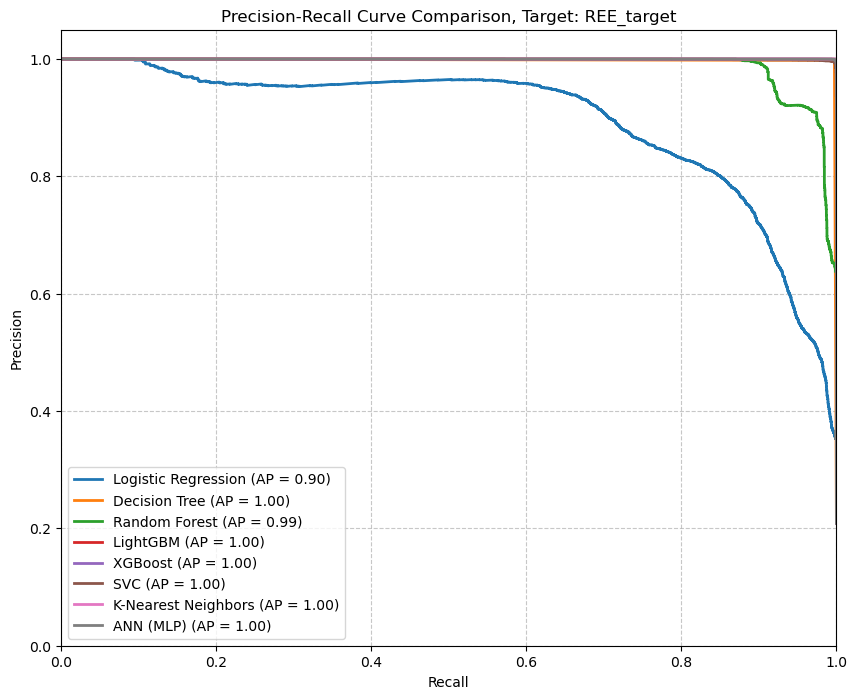

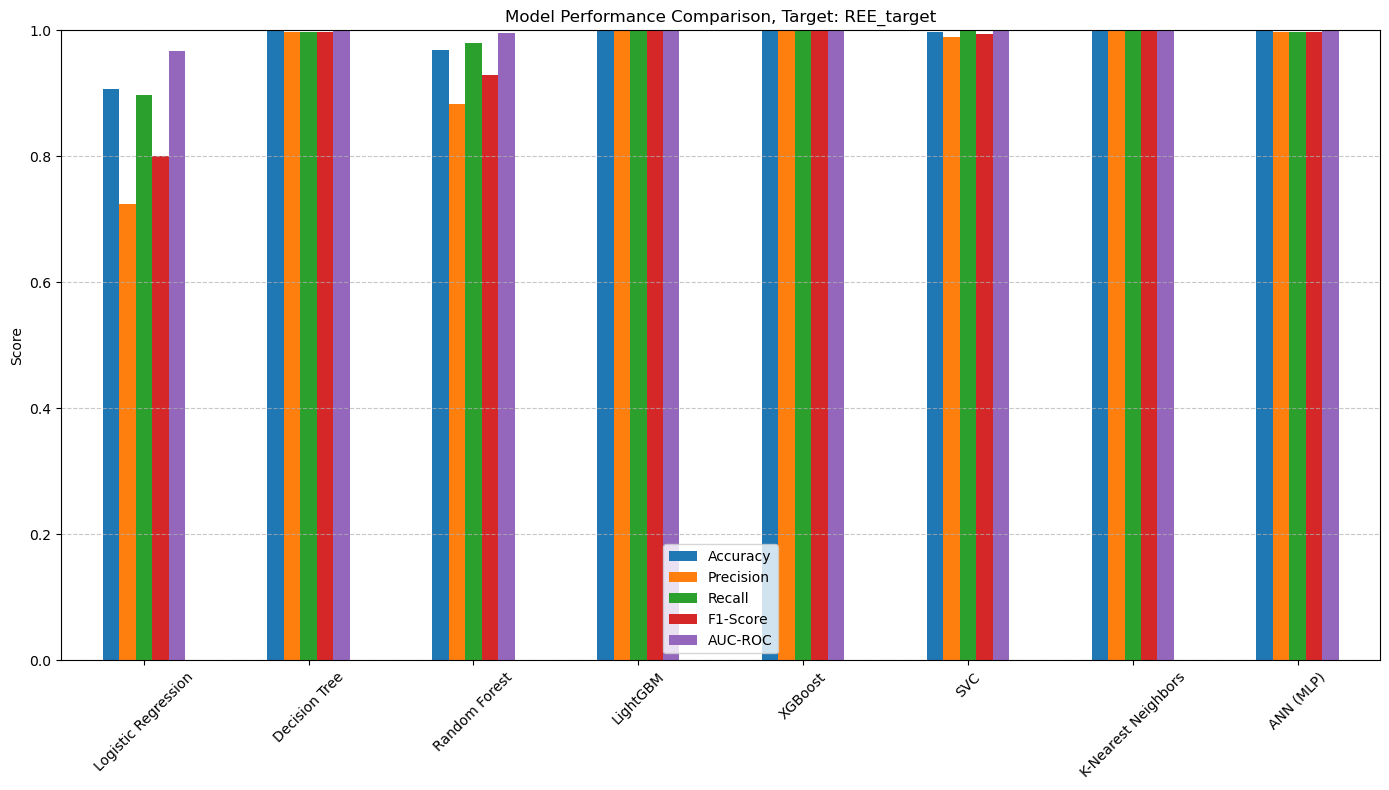

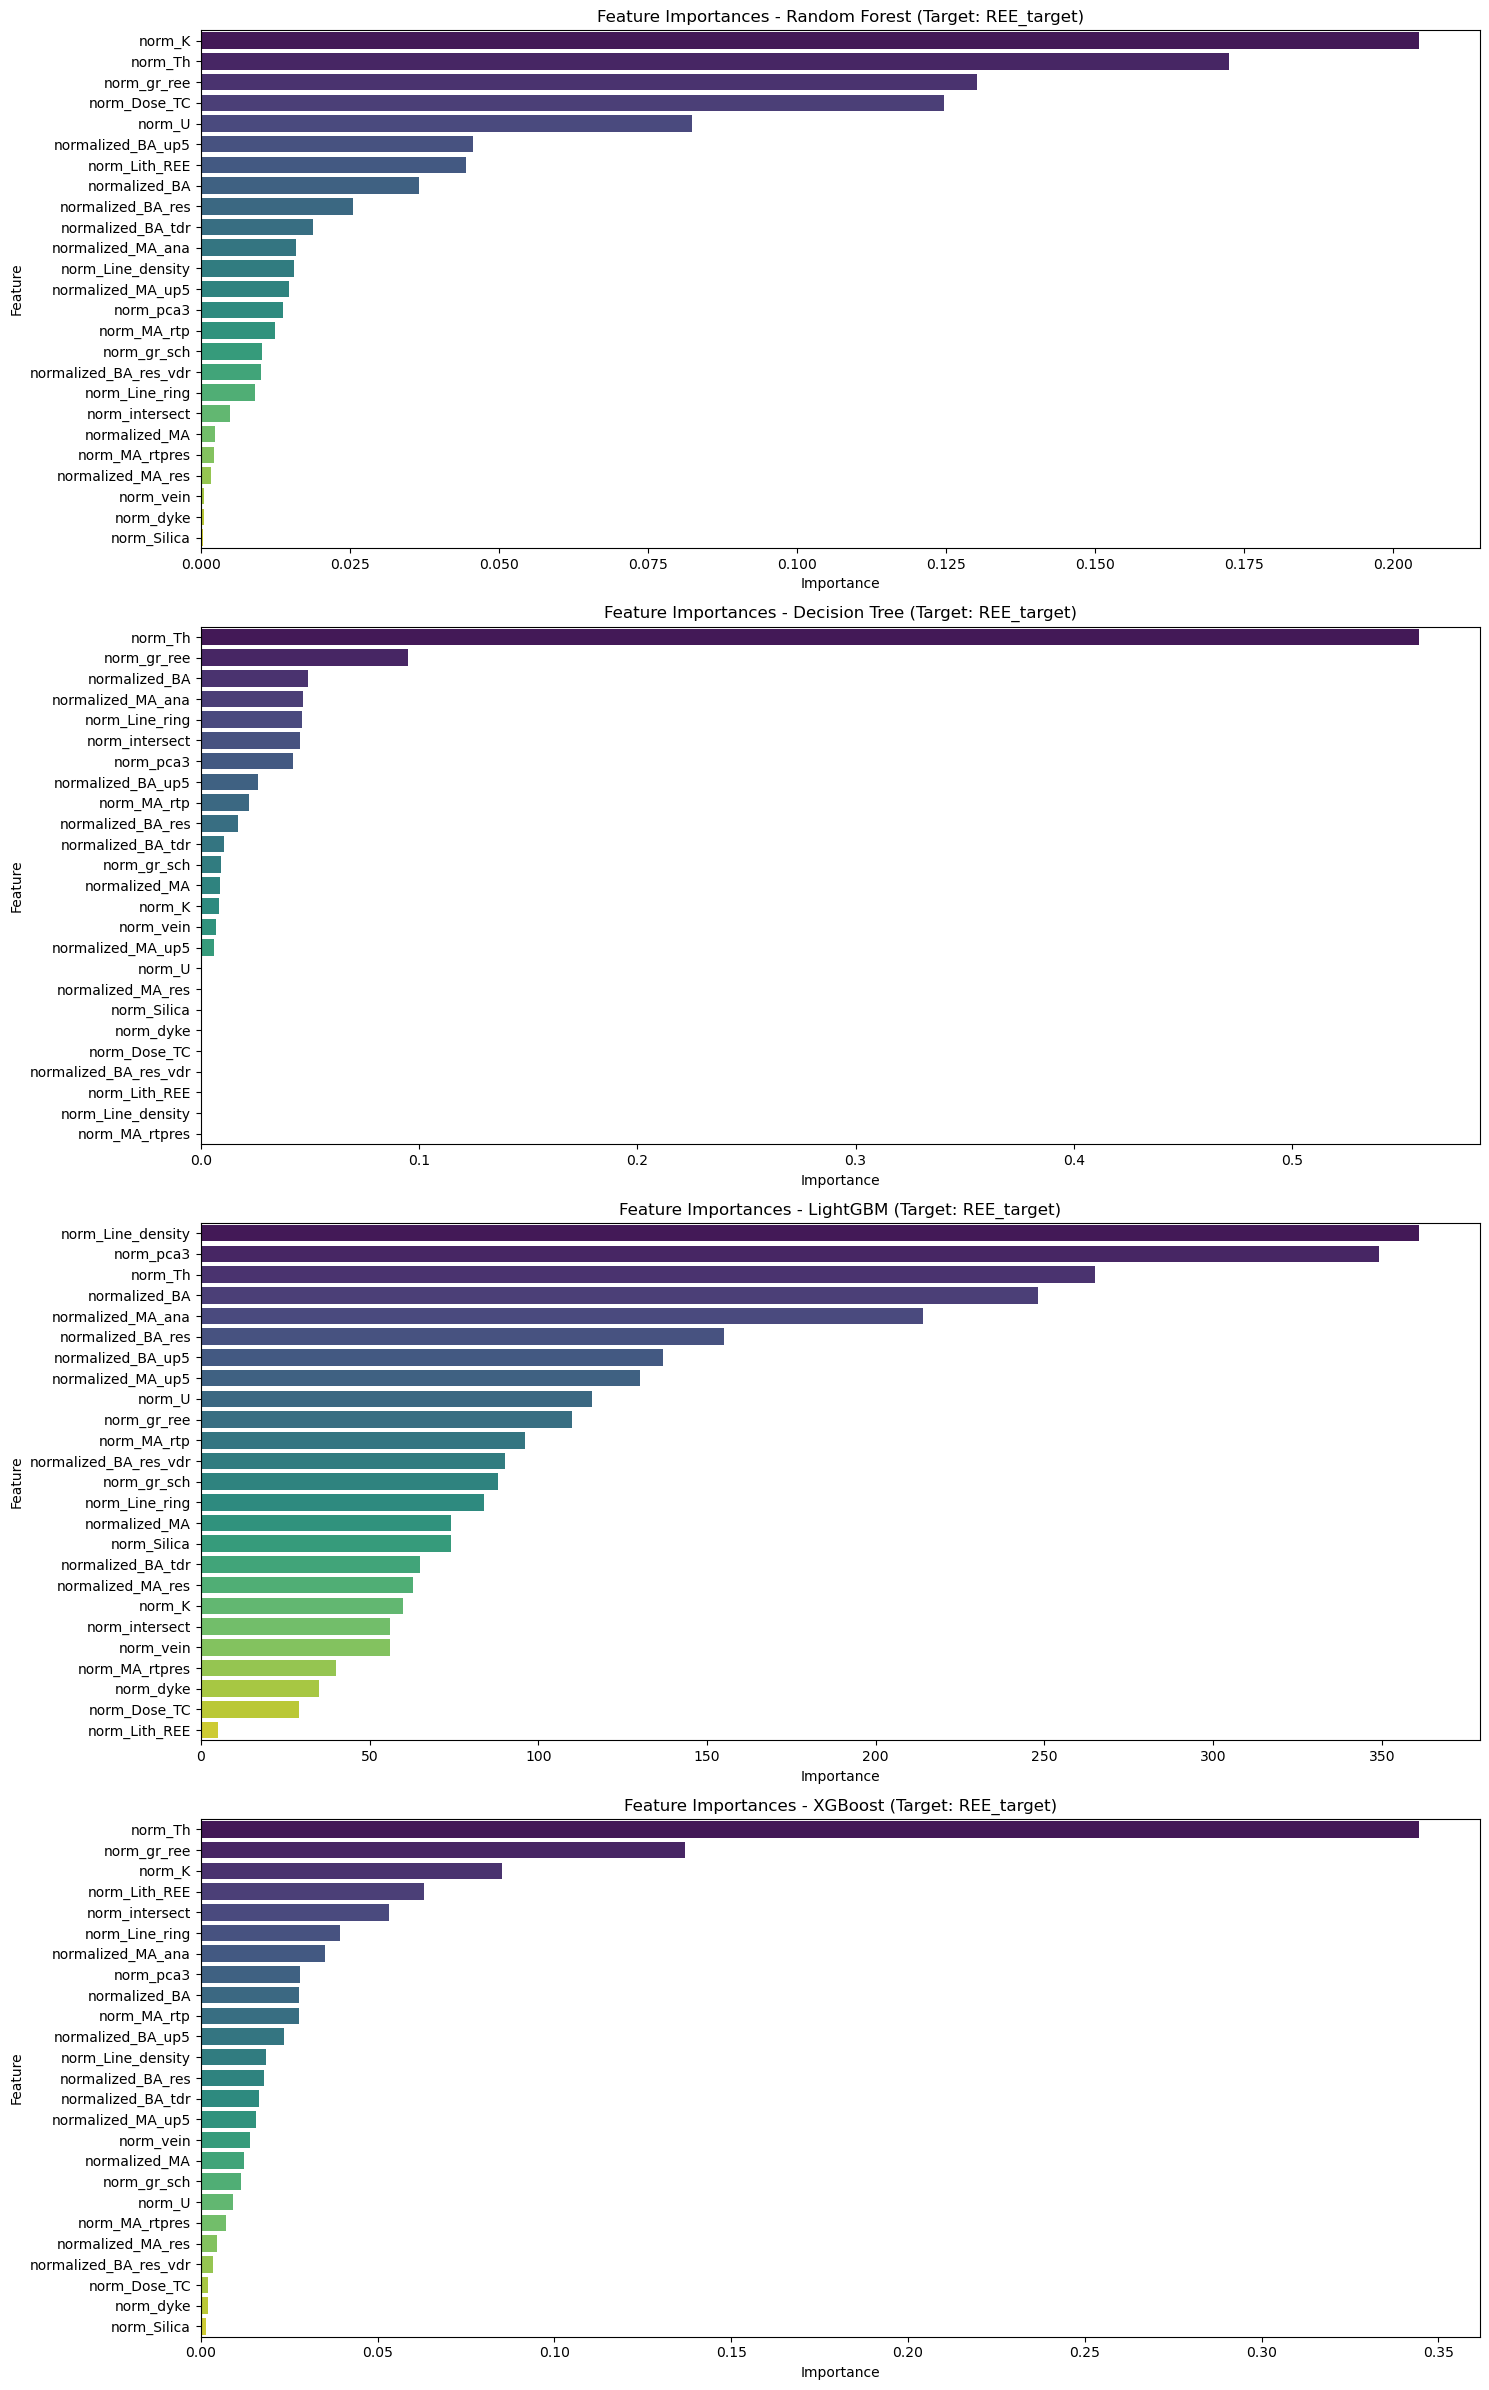

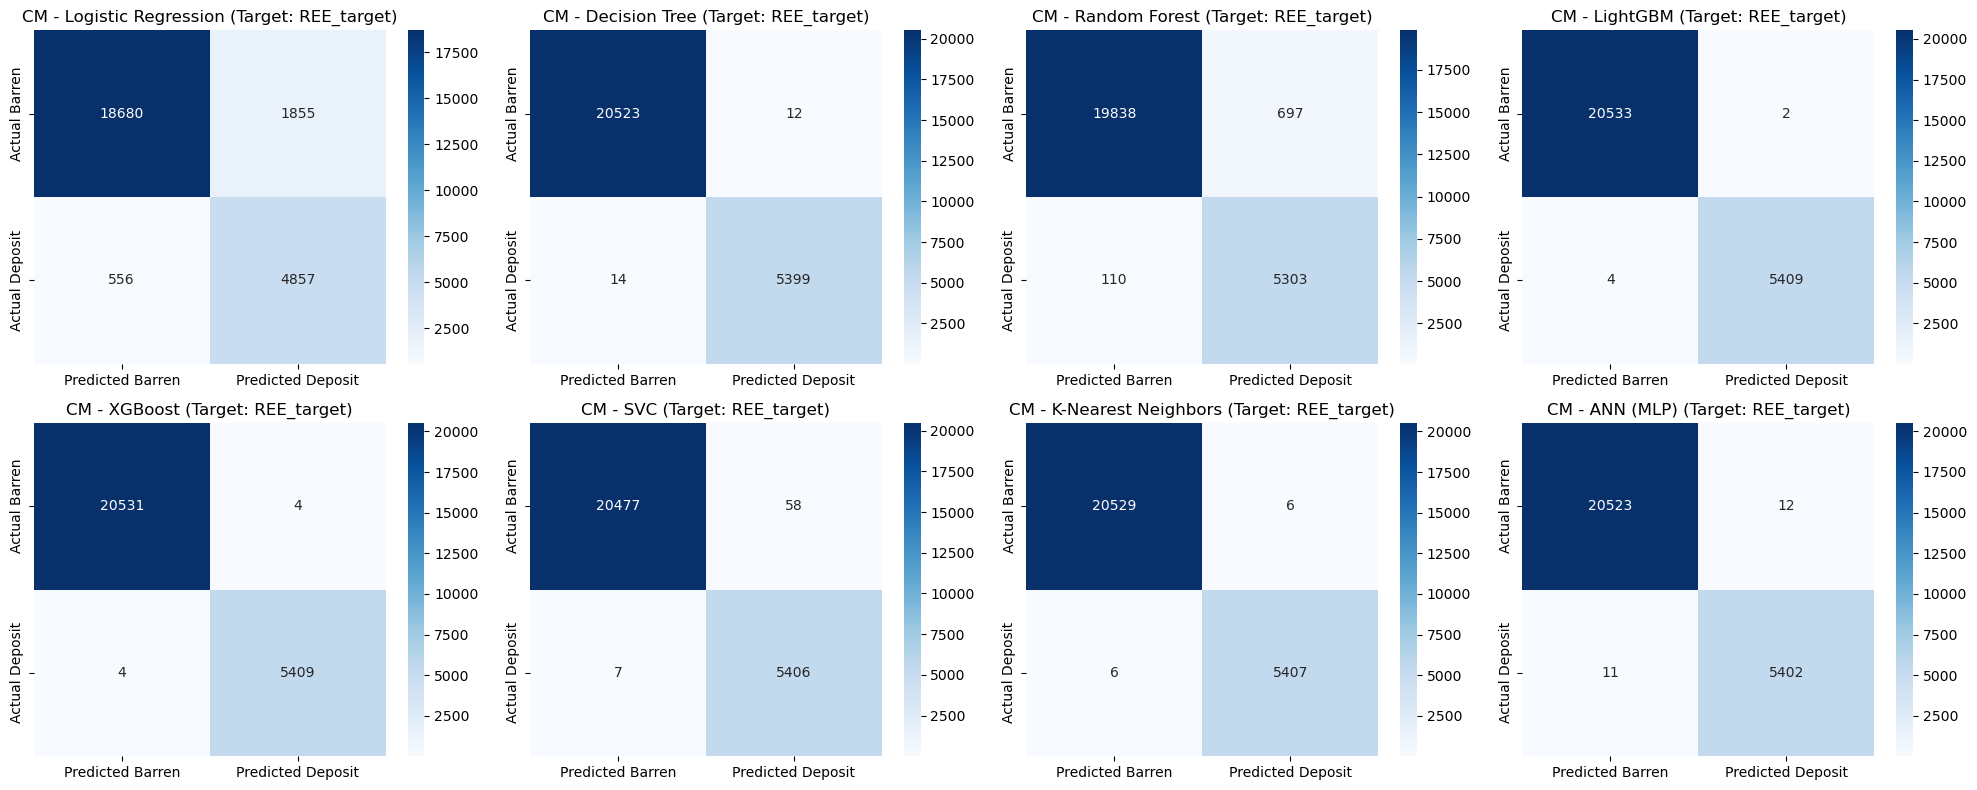


Comparative plots generated for model evaluation.


In [10]:
# Model Comparison and Visualization

print("Generating comparative plots...")

# --- 1. ROC Curve Comparison ---
plt.figure(figsize=(10, 8))
for name, preds in model_predictions.items():
    if not np.all(preds['y_pred_proba'] == 0): 
        fpr, tpr, _ = roc_curve(y_test, preds['y_pred_proba'])
        roc_auc = roc_auc_score(y_test, preds['y_pred_proba'])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    else:
        print(f"Skipping ROC curve for {name} due to missing probability predictions.")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve Comparison, Target: {target_column}')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(r'E:\Hackathon\Model\REE\ROC.png', dpi=300, bbox_inches='tight')                               # User input
plt.show()

# --- 2. Precision-Recall Curve Comparison ---
plt.figure(figsize=(10, 8))
for name, preds in model_predictions.items():
    # Only plot if probabilities were available
    if not np.all(preds['y_pred_proba'] == 0):
        precision, recall, _ = precision_recall_curve(y_test, preds['y_pred_proba'])
        from sklearn.metrics import average_precision_score
        ap = average_precision_score(y_test, preds['y_pred_proba'])
        plt.plot(recall, precision, lw=2, label=f'{name} (AP = {ap:.2f})')
    else:
        print(f"Skipping Precision-Recall curve for {name} due to missing probability predictions.")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Comparison, Target: {target_column}')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(r'E:\Hackathon\Model\REE\Precision-Recall.png', dpi=300, bbox_inches='tight')                   # User input
plt.show()

# --- 3. Comparison of Key Metrics (Bar Plot) ---
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
performance_for_plot = performance_df[metrics_to_plot].dropna(subset=['AUC-ROC'])
performance_for_plot.plot(kind='bar', figsize=(14, 8), rot=45)
plt.title(f'Model Performance Comparison, Target: {target_column}')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(r'E:\Hackathon\Model\REE\Model_Performance_Comparison.png', dpi=300, bbox_inches='tight')      # User input
plt.show()

# --- 4. Feature Importance Plots (for tree-based models) ---
tree_based_models = ['Random Forest', 'Decision Tree', 'LightGBM', 'XGBoost']
plt.figure(figsize=(15, 6 * len(tree_based_models))) 
for i, name in enumerate(tree_based_models):
    if name in models and hasattr(models[name], 'feature_importances_'):
        plt.subplot(len(tree_based_models), 1, i + 1)
        feature_importances = pd.Series(models[name].feature_importances_, index=X.columns).sort_values(ascending=False)
        sns.barplot(x=feature_importances.values, y=feature_importances.index, hue=feature_importances.index, palette='viridis', legend=False)
        plt.title(f'Feature Importances - {name} (Target: {target_column})')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
    else:
        print(f"Skipping Feature Importance for {name} (not a tree-based model or importances not available).")
plt.tight_layout()
plt.savefig(r'E:\Hackathon\Model\REE\Feature_Importance.png', dpi=300, bbox_inches='tight')               # User input
plt.show()

# --- 5. Confusion Matrices ---
num_models = len(models)
cols = 4
rows = (num_models + cols - 1) // cols
#
plt.figure(figsize=(5 * cols, 4 * rows))
for i, (name, preds) in enumerate(model_predictions.items()):
     plt.subplot(rows, cols, i + 1)
     cm = confusion_matrix(y_test, preds['y_pred'])
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Predicted Barren', 'Predicted Deposit'],
                 yticklabels=['Actual Barren', 'Actual Deposit'])
     plt.title(f'CM - {name} (Target: {target_column})')
plt.tight_layout()
plt.savefig(r'E:\Hackathon\Model\REE\Confusion_Matrices.png', dpi=300, bbox_inches='tight')                # User input
plt.show()

print("\nComparative plots generated for model evaluation.")

In [11]:
print("Preparing data for prospectivity map generation...")
df_for_mapping = df.copy()

X_all_scaled_df = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
print("\nEnsured X_all_scaled is a DataFrame with feature names to prevent warnings.")

Preparing data for prospectivity map generation...

Ensured X_all_scaled is a DataFrame with feature names to prevent warnings.


In [12]:
print("\nSetting up GeoTIFF export parameters...")

# Get unique sorted coordinates to infer resolution and bounds
unique_x = np.sort(df_for_mapping['X_Coordinate'].unique())
unique_y = np.sort(df_for_mapping['Y_Coordinate'].unique())

# Infer resolution (smallest difference between consecutive unique coordinates)
x_res = np.min(np.diff(unique_x)) if len(unique_x) > 1 else 1.0
y_res = np.min(np.diff(unique_y)) if len(unique_y) > 1 else 1.0

# Calculate raster bounds (adjust by half resolution to get outer edges of grid cells)
min_x_grid = np.min(unique_x) - x_res / 2
max_x_grid = np.max(unique_x) + x_res / 2
min_y_grid = np.min(unique_y) - y_res / 2
max_y_grid = np.max(unique_y) + y_res / 2

# Calculate raster dimensions (number of cells along X and Y axes)
raster_width = len(unique_x)
raster_height = len(unique_y)

# Create affine transform for rasterio
geotiff_transform = Affine(x_res, 0.0, min_x_grid, 0.0, -y_res, max_y_grid)

# The CRS should be the same as your projected_crs defined below
projected_crs = "EPSG:32643" 
geotiff_crs = projected_crs 

nodata_value = np.nan

print(f"Inferred grid resolution: X={x_res}, Y={y_res}")
print(f"Inferred raster dimensions: Width={raster_width}, Height={raster_height}")
print(f"Inferred raster bounds: {min_x_grid, min_y_grid, max_x_grid, max_y_grid}")
print(f"GeoTIFF CRS set to: {geotiff_crs}")


Setting up GeoTIFF export parameters...
Inferred grid resolution: X=100.01231893943623, Y=100.00030662864447
Inferred raster dimensions: Width=1894, Height=2227
Inferred raster bounds: (np.float64(607328.2803476272), np.float64(1520402.0949951368), np.float64(796751.612419077), np.float64(1743102.777857702))
GeoTIFF CRS set to: EPSG:32643


In [13]:
print("\nIdentifying top 3 models and setting up output directories...")
# --- Manual selection of top 3 model names ---
top_3_model_names = [
    'Random Forest',  
    #'XGBoost', 
    'LightGBM',
    #'SVC',
    'ANN (MLP)',
    #'K-Nearest Neighbors'
]
if not top_3_model_names:
    print("Error: No models selected. Please ensure the 'top_3_model_names' list is populated.")
else:
    print(f"\nManually selected top 3 models: {top_3_model_names}")

# Create output directories if they don't exist
output_png_dir = r'E:\Hackathon\Model\REE\prospectivity_maps_png'                                         # User input                          
output_geotiff_dir = r'E:\Hackathon\Model\REE\prospectivity_maps_geotiff'                                 # User input
os.makedirs(output_png_dir, exist_ok=True)
os.makedirs(output_geotiff_dir, exist_ok=True)
print(f"Output directories created: {output_png_dir}, {output_geotiff_dir}")


Identifying top 3 models and setting up output directories...

Manually selected top 3 models: ['Random Forest', 'LightGBM', 'ANN (MLP)']
Output directories created: E:\Hackathon\Model\REE\prospectivity_maps_png, E:\Hackathon\Model\REE\prospectivity_maps_geotiff


In [14]:
print("--- Initial Setup and Common Variable Checks ---")
required_vars = [
    'X_all_scaled_df', 'df_for_mapping', 'models', 'projected_crs',
    'output_png_dir', 'output_geotiff_dir', 'geotiff_transform',
    'raster_width', 'raster_height', 'geotiff_crs', 'nodata_value',
    'min_x_grid', 'max_x_grid', 'min_y_grid', 'max_y_grid', 'x_res', 'y_res',
    'all_columns', 'top_3_model_names'
]

# Perform checks to ensure all required variables are present and valid
for var_name in required_vars:
    if var_name not in locals():
        raise NameError(f"Error: Required variable '{var_name}' is not defined. Please ensure all preceding cells have been run correctly.")
    if var_name in ['X_all_scaled_df', 'df_for_mapping'] and locals()[var_name].empty:
        raise ValueError(f"Error: DataFrame '{var_name}' is empty. Please check data loading/processing in previous cells.")

# Additional check for top_3_model_names
if not top_3_model_names or len(top_3_model_names) == 0:
    raise ValueError("Error: 'top_3_model_names' is empty or not properly populated. Cannot proceed with mapping.")
elif len(top_3_model_names) < 3:
    print(f"Warning: Only {len(top_3_model_names)} models found in 'top_3_model_names'. Subsequent cells might skip if models are missing.")

print("All required variables are checked and available.")
print("Proceed to the next cells to generate maps for each model.")

def generate_and_save_map(model_name, df_map_data, X_all_scaled_df, models,
                          output_png_dir, output_geotiff_dir,
                          projected_crs, geotiff_transform, raster_width, raster_height,
                          geotiff_crs, nodata_value, min_x_grid, max_x_grid,
                          min_y_grid, max_y_grid, x_res, y_res, gold_mask_column):
    """
    Generates a prospectivity map (PNG and GeoTIFF) for a given model.
    """
    print(f"\n--- Processing map for: {model_name} ---")

    score_column = f'prospectivity_score_{model_name.replace(" ", "_")}'

    if model_name in models and hasattr(models[model_name], 'predict_proba'):
        # Predict probabilities on the full, scaled dataset
        prospectivity_scores = models[model_name].predict_proba(X_all_scaled_df)[:, 1]
        df_map_data[score_column] = prospectivity_scores
        print(f"Calculated prospectivity scores for: {model_name}")

        # Create a GeoDataFrame
        geometry = [Point(xy) for xy in zip(df_map_data['X_Coordinate'], df_map_data['Y_Coordinate'])]
        gdf = gpd.GeoDataFrame(df_map_data, geometry=geometry, crs=projected_crs)
        print(f"Created GeoDataFrame with CRS: {gdf.crs}")

        # Plot Prospectivity Map (PNG export)
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))

        gdf.plot(column=score_column, cmap='viridis', linewidth=0.01, ax=ax,
                 marker='s', markersize=1, alpha=0.8,
                 legend=True, legend_kwds={'label': "Prospectivity Score (0-1)", 'orientation': "vertical"})

        # Optional: Overlay known deposit locations if available
        if gold_mask_column in gdf.columns:
            deposits_gdf = gdf[gdf[gold_mask_column] == 1]
            if not deposits_gdf.empty:
                deposits_gdf.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='black', alpha=0.7, label='Known Deposits')
                ax.legend(loc='upper right')

        ax.set_title(f'Mineral Prospectivity Map - {model_name} (Target: {target_column})')
        ax.set_xlabel('X_Coordinate (meters)')
        ax.set_ylabel('Y_Coordinate (meters)')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.5)

        png_output_path = os.path.join(output_png_dir, f'prospectivity_map_{model_name.replace(" ", "_")}.png')
        plt.savefig(png_output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        print(f"Saved PNG for '{model_name}' to: {png_output_path}")

        # Export to GeoTIFF
        x_coords_grid = np.linspace(min_x_grid + x_res/2, max_x_grid - x_res/2, raster_width)
        y_coords_grid = np.linspace(min_y_grid + y_res/2, max_y_grid - y_res/2, raster_height)

        raster_data = np.full((raster_height, raster_width), nodata_value, dtype=np.float32)

        x_indices = np.digitize(gdf['X_Coordinate'], x_coords_grid) - 1
        y_indices = np.digitize(gdf['Y_Coordinate'], y_coords_grid) - 1

        x_indices = np.clip(x_indices, 0, raster_width - 1)
        y_indices = np.clip(y_indices, 0, raster_height - 1)

        raster_data[y_indices, x_indices] = gdf[score_column].values

        raster_data = raster_data[::-1, :]
        
        geotiff_output_path = os.path.join(output_geotiff_dir, f'prospectivity_map_{model_name.replace(" ", "_")}.tif')

        with rasterio.open(
            geotiff_output_path,
            'w',
            driver='GTiff',
            height=raster_height,
            width=raster_width,
            count=1,
            dtype=raster_data.dtype,
            crs=geotiff_crs,
            transform=geotiff_transform,
            nodata=nodata_value
        ) as dst:
            dst.write(raster_data, 1)

        print(f"Saved GeoTIFF for '{model_name}' to: {geotiff_output_path}")

    else:
        print(f"Skipping '{model_name}' for map generation (model not found or lacks predict_proba).")

--- Initial Setup and Common Variable Checks ---
All required variables are checked and available.
Proceed to the next cells to generate maps for each model.



--- Processing map for: Random Forest ---
Calculated prospectivity scores for: Random Forest
Created GeoDataFrame with CRS: EPSG:32643


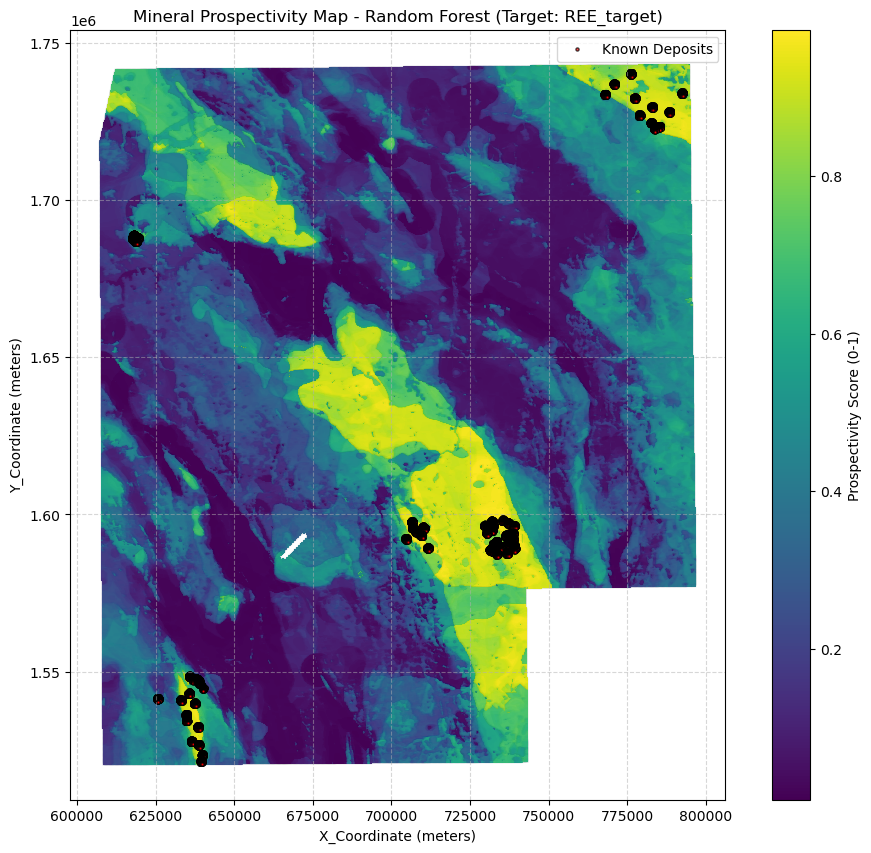

Saved PNG for 'Random Forest' to: E:\Hackathon\Model\REE\prospectivity_maps_png\prospectivity_map_Random_Forest.png
Saved GeoTIFF for 'Random Forest' to: E:\Hackathon\Model\REE\prospectivity_maps_geotiff\prospectivity_map_Random_Forest.tif

Top Model execution complete!


In [15]:
# Assuming 'top_3_model_names' is populated with at least one model name
if len(top_3_model_names) >= 1:
    model_name_1 = top_3_model_names[0]
    # Create a copy of df_for_mapping to avoid modifying it in place for subsequent cells
    df_map_data_1 = df_for_mapping[['X_Coordinate', 'Y_Coordinate', all_columns[-1]]].copy()

    generate_and_save_map(
        model_name_1, df_map_data_1, X_all_scaled_df, models,
        output_png_dir, output_geotiff_dir,
        projected_crs, geotiff_transform, raster_width, raster_height,
        geotiff_crs, nodata_value, min_x_grid, max_x_grid,
        min_y_grid, max_y_grid, x_res, y_res, all_columns[-1]
    )
else:
    print("Not enough models in 'top_3_model_names' to generate a map for the top model.")

print("\nTop Model execution complete!")


--- Processing map for: LightGBM ---
Calculated prospectivity scores for: LightGBM
Created GeoDataFrame with CRS: EPSG:32643


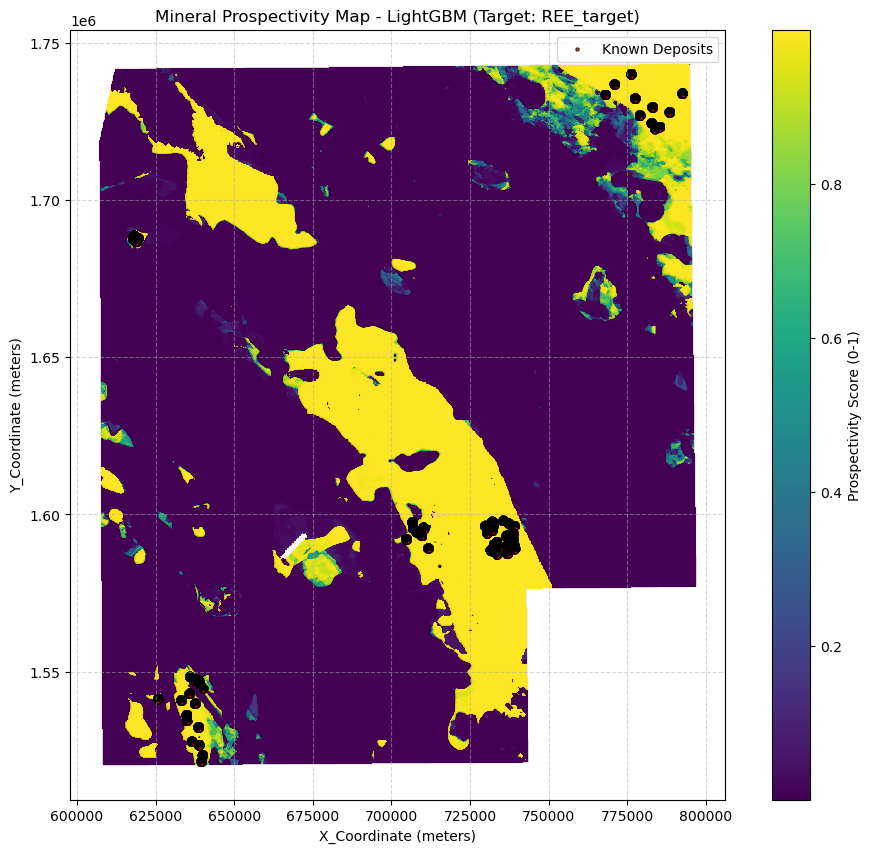

Saved PNG for 'LightGBM' to: E:\Hackathon\Model\REE\prospectivity_maps_png\prospectivity_map_LightGBM.png
Saved GeoTIFF for 'LightGBM' to: E:\Hackathon\Model\REE\prospectivity_maps_geotiff\prospectivity_map_LightGBM.tif

Second Top Model execution complete!


In [16]:
# Assuming 'top_3_model_names' is populated with at least two model names
if len(top_3_model_names) >= 2:
    model_name_2 = top_3_model_names[1]
    # Create a copy of df_for_mapping
    df_map_data_2 = df_for_mapping[['X_Coordinate', 'Y_Coordinate', all_columns[-1]]].copy()

    generate_and_save_map(
        model_name_2, df_map_data_2, X_all_scaled_df, models,
        output_png_dir, output_geotiff_dir,
        projected_crs, geotiff_transform, raster_width, raster_height,
        geotiff_crs, nodata_value, min_x_grid, max_x_grid,
        min_y_grid, max_y_grid, x_res, y_res, all_columns[-1]
    )
else:
    print("Not enough models in 'top_3_model_names' to generate a map for the second top model.")

print("\nSecond Top Model execution complete!")


--- Processing map for: ANN (MLP) ---
Calculated prospectivity scores for: ANN (MLP)
Created GeoDataFrame with CRS: EPSG:32643


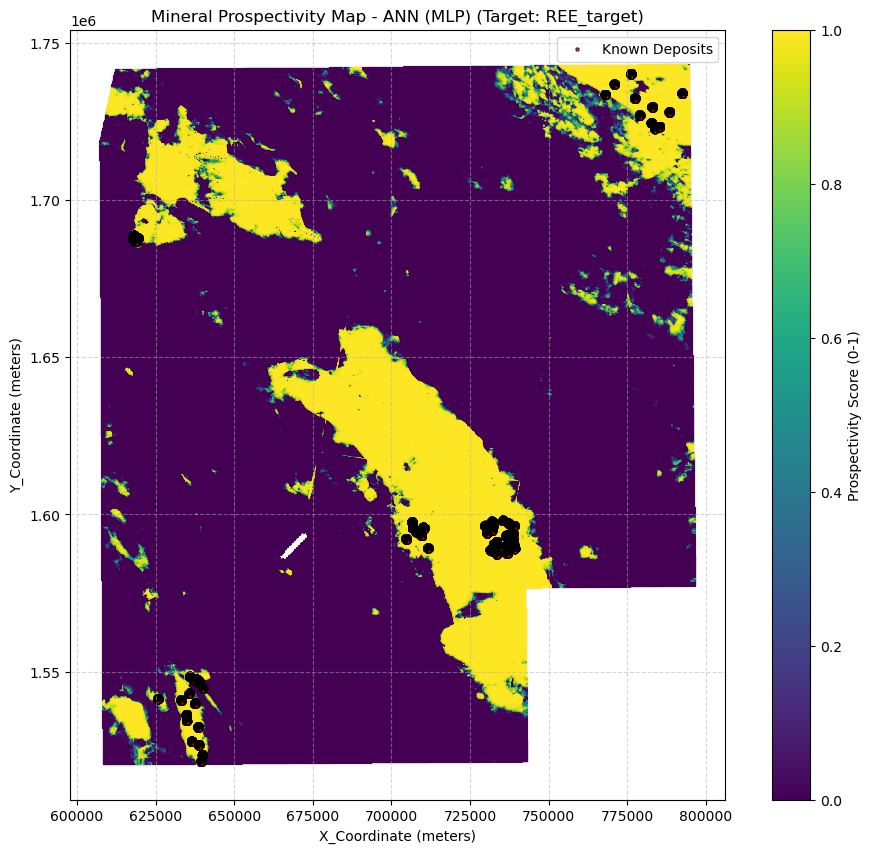

Saved PNG for 'ANN (MLP)' to: E:\Hackathon\Model\REE\prospectivity_maps_png\prospectivity_map_ANN_(MLP).png
Saved GeoTIFF for 'ANN (MLP)' to: E:\Hackathon\Model\REE\prospectivity_maps_geotiff\prospectivity_map_ANN_(MLP).tif

Third Top Model execution complete!


In [17]:
# Assuming 'top_3_model_names' is populated with at least three model names
if len(top_3_model_names) >= 3:
    model_name_3 = top_3_model_names[2]
    # Create a copy of df_for_mapping
    df_map_data_3 = df_for_mapping[['X_Coordinate', 'Y_Coordinate', all_columns[-1]]].copy()

    generate_and_save_map(
        model_name_3, df_map_data_3, X_all_scaled_df, models,
        output_png_dir, output_geotiff_dir,
        projected_crs, geotiff_transform, raster_width, raster_height,
        geotiff_crs, nodata_value, min_x_grid, max_x_grid,
        min_y_grid, max_y_grid, x_res, y_res, all_columns[-1]
    )
else:
    print("Not enough models in 'top_3_model_names' to generate a map for the third top model.")

print("\nThird Top Model execution complete!")


--- Generating Combined Prospectivity Map (Score > 0.85 for all top 3 models) ---
Calculating scores for top 3 models and filtering for score > 0.85...
 - Scores calculated for: Random Forest
 - Scores calculated for: LightGBM
 - Scores calculated for: ANN (MLP)
Filtering data where ALL top 3 models have prospectivity score > 0.85...
Found 337257 locations meeting the combined criteria.
Created GeoDataFrame for combined map with CRS: EPSG:32643


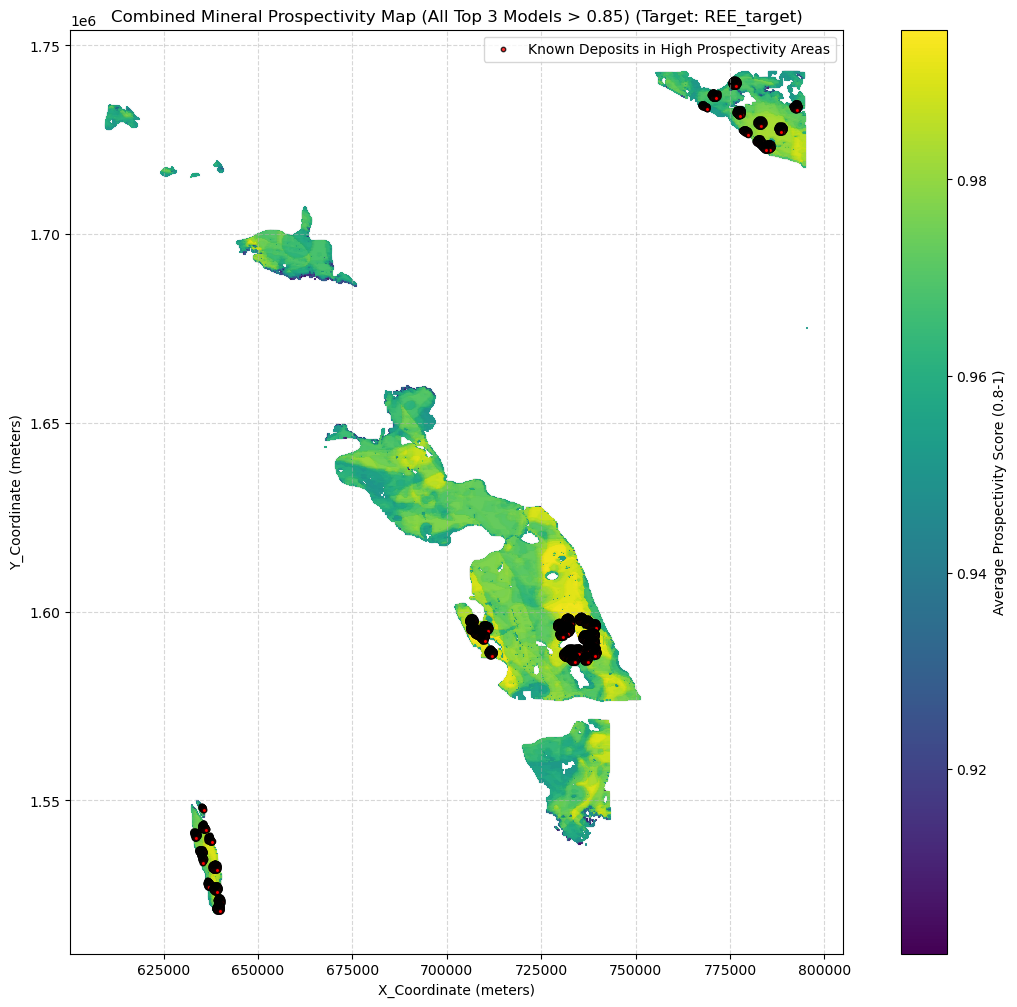

Saved PNG for combined map to: E:\Hackathon\Model\REE\prospectivity_maps_png\prospectivity_map_combined_top3_gt_085.png
Saved GeoTIFF for combined map to: E:\Hackathon\Model\REE\prospectivity_maps_geotiff\prospectivity_map_combined_top3_gt_085.tif

Combined map generation complete!


In [19]:
print("\n--- Generating Combined Prospectivity Map (Score > 0.85 for all top 3 models) ---")
required_vars = [
    'X_all_scaled_df', 'df_for_mapping', 'models', 'projected_crs',
    'output_png_dir', 'output_geotiff_dir', 'geotiff_transform',
    'raster_width', 'raster_height', 'geotiff_crs', 'nodata_value',
    'min_x_grid', 'max_x_grid', 'min_y_grid', 'max_y_grid', 'x_res', 'y_res',
    'all_columns', 'top_3_model_names'
]

for var_name in required_vars:
    if var_name not in locals():
        raise NameError(f"Error: Required variable '{var_name}' is not defined. Please ensure all preceding cells (including Initial Setup) have been run correctly.")
    if var_name in ['X_all_scaled_df', 'df_for_mapping'] and locals()[var_name].empty:
        raise ValueError(f"Error: DataFrame '{var_name}' is empty. Please check data loading/processing in previous cells.")

if not top_3_model_names or len(top_3_model_names) < 3:
    print("Error: 'top_3_model_names' does not contain at least 3 models. Cannot generate combined map.")
else:
    df_combined_map_data = df_for_mapping[['X_Coordinate', 'Y_Coordinate', all_columns[-1]]].copy()
    threshold = 0.85                                                                                   # User input to change threshold
    model_score_columns = []
    
    print(f"Calculating scores for top 3 models and filtering for score > {threshold}...")

    # Calculate prospectivity scores for each of the top three models
    for i in range(3): # Iterate through the top 3 models
        model_name = top_3_model_names[i]
        score_column_name = f'prospectivity_score_{model_name.replace(" ", "_")}'
        model_score_columns.append(score_column_name)

        if model_name in models and hasattr(models[model_name], 'predict_proba'):
            prospectivity_scores = models[model_name].predict_proba(X_all_scaled_df)[:, 1]
            df_combined_map_data[score_column_name] = prospectivity_scores
            print(f" - Scores calculated for: {model_name}")
        else:
            print(f" - Warning: Model '{model_name}' not found or lacks predict_proba. Skipping for combined map.")
            model_score_columns.pop() # Remove if model isn't valid

    if len(model_score_columns) < 3:
        print("Error: Not all top 3 models could be processed. Cannot create combined map based on all three.")
    else:
        # 2. Filter data where prospectivity score is > 0.80 for ALL top three models
        print(f"Filtering data where ALL top 3 models have prospectivity score > {threshold}...")
        
        # Initialize filter with the first model's condition
        combined_filter = (df_combined_map_data[model_score_columns[0]] > threshold)
        
        # Add conditions for the remaining models
        for col in model_score_columns[1:]:
            combined_filter = combined_filter & (df_combined_map_data[col] > threshold)

        df_filtered = df_combined_map_data[combined_filter].copy()

        if df_filtered.empty:
            print(f"No locations found where all top 3 models predict a prospectivity score > {threshold}.")
        else:
            print(f"Found {len(df_filtered)} locations meeting the combined criteria.")

            df_filtered['average_prospectivity_score'] = df_filtered[model_score_columns].mean(axis=1)

            # 3. Create a GeoDataFrame from the filtered data
            geometry_filtered = [Point(xy) for xy in zip(df_filtered['X_Coordinate'], df_filtered['Y_Coordinate'])]
            gdf_filtered = gpd.GeoDataFrame(df_filtered, geometry=geometry_filtered, crs=projected_crs)
            print(f"Created GeoDataFrame for combined map with CRS: {gdf_filtered.crs}")

            # 4. Generate and Save Single PNG Map
            fig_combined, ax_combined = plt.subplots(1, 1, figsize=(15, 12))

            gdf_filtered.plot(column='average_prospectivity_score', cmap='viridis', linewidth=0.01, ax=ax_combined,
                             marker='s', markersize=2, alpha=0.9, # Slightly larger markers for sparse data
                             legend=True, legend_kwds={'label': "Average Prospectivity Score (0.8-1)", 'orientation': "vertical"})

            # Optional: Overlay known deposit locations if 'Gold_mask' is available
            if all_columns[-1] in gdf_filtered.columns:
                deposits_gdf_combined = gdf_filtered[gdf_filtered[all_columns[-1]] == 1]
                if not deposits_gdf_combined.empty:
                    deposits_gdf_combined.plot(ax=ax_combined, marker='o', color='red', markersize=10, edgecolor='black', alpha=0.8, label='Known Deposits in High Prospectivity Areas')
                    ax_combined.legend(loc='upper right')

            ax_combined.set_title(f'Combined Mineral Prospectivity Map (All Top 3 Models > {threshold}) (Target: {target_column})')
            ax_combined.set_xlabel('X_Coordinate (meters)')
            ax_combined.set_ylabel('Y_Coordinate (meters)')
            ax_combined.set_aspect('equal', adjustable='box')
            ax_combined.grid(True, linestyle='--', alpha=0.5)

            png_output_path_combined = os.path.join(output_png_dir, f'prospectivity_map_combined_top3_gt_{str(threshold).replace(".", "")}.png')
            plt.savefig(png_output_path_combined, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close(fig_combined)
            print(f"Saved PNG for combined map to: {png_output_path_combined}")

            # 5. Generate and Save Single GeoTIFF Map
            raster_data_combined = np.full((raster_height, raster_width), nodata_value, dtype=np.float32)
    
            x_coords_grid = np.linspace(min_x_grid + x_res/2, max_x_grid - x_res/2, raster_width)
            y_coords_grid = np.linspace(min_y_grid + y_res/2, max_y_grid - y_res/2, raster_height)
    
            # Map filtered point coordinates to grid indices
            x_indices_combined = np.digitize(gdf_filtered['X_Coordinate'], x_coords_grid) - 1
            y_indices_combined = np.digitize(gdf_filtered['Y_Coordinate'], y_coords_grid) - 1
    
            x_indices_combined = np.clip(x_indices_combined, 0, raster_width - 1)
            y_indices_combined = np.clip(y_indices_combined, 0, raster_height - 1)
    
            raster_data_combined[y_indices_combined, x_indices_combined] = gdf_filtered['average_prospectivity_score'].values
    
            raster_data_combined = raster_data_combined[::-1, :]
    
            geotiff_output_path_combined = os.path.join(output_geotiff_dir, f'prospectivity_map_combined_top3_gt_{str(threshold).replace(".", "")}.tif')

            with rasterio.open(
                geotiff_output_path_combined,
                'w',
                driver='GTiff',
                height=raster_height,
                width=raster_width,
                count=1,
                dtype=raster_data_combined.dtype,
                crs=geotiff_crs,
                transform=geotiff_transform,
                nodata=nodata_value
            ) as dst:
                dst.write(raster_data_combined, 1)

            print(f"Saved GeoTIFF for combined map to: {geotiff_output_path_combined}")

print("\nCombined map generation complete!")